<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Tech_Talk_Analise_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers

     |████████████████████████████████| 2.1MB 3.8MB/s 
     |████████████████████████████████| 3.3MB 32.2MB/s 
     |████████████████████████████████| 901kB 46.8MB/s 


In [2]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt

In [73]:
text = 'O banco tem o melhor atendimento digital, podemos acessar o app do banco até mesmo sentado em um banco da praça.'

In [96]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

text_tokenized = tokenizer.encode_plus(text, return_tensors='pt')
model = BertModel.from_pretrained('bert-base-multilingual-uncased', output_hidden_states=True, return_dict=True)

with torch.no_grad():
    outputs = model(text_tokenized['input_ids'])

In [97]:
len(outputs['hidden_states']), outputs['last_hidden_state'].shape, outputs['pooler_output'].shape

(13, torch.Size([1, 28, 768]), torch.Size([1, 768]))

In [99]:
13*1*28*768

279552

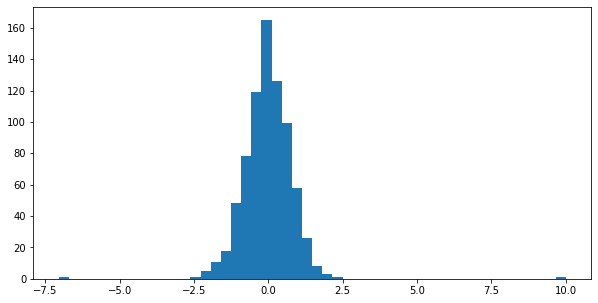

In [100]:
layer = 6
batch = 0
token = 6
vec = outputs['hidden_states'][layer][batch][token] #layer, batch, token
plt.figure(figsize=(10,5))
plt.hist(vec, bins=50)
plt.show()

In [101]:
token_embds = torch.stack(outputs['hidden_states'], dim=0)
print(token_embds.shape)
token_embds = token_embds.squeeze(1)
print(token_embds.shape)
token_embds = token_embds.permute(1,0,2)
print(token_embds.shape)

torch.Size([13, 1, 28, 768])
torch.Size([13, 28, 768])
torch.Size([28, 13, 768])


In [102]:
token_embds_vec = []

for tok in token_embds:
    cat_vec = torch.cat((
        tok[-1],tok[-2]), dim=0)
    token_embds_vec.append(cat_vec)    

len(token_embds_vec), len(token_embds_vec[0])

(28, 1536)

In [103]:
for i, t in enumerate(tokenizer.tokenize(text), 1):
    
    if t == 'banco': print(i, t, '****')
    else: print(i, t)

1 o
2 banco ****
3 tem
4 o
5 melhor
6 aten
7 ##dimento
8 digital
9 ,
10 podemos
11 ace
12 ##ssar
13 o
14 app
15 do
16 banco ****
17 ate
18 mesmo
19 sent
20 ##ado
21 em
22 um
23 banco ****
24 da
25 praca
26 .


In [81]:
from scipy.spatial.distance import cosine

In [104]:
# bancos instituições
same_bank = 1 - cosine(token_embds_vec[2], token_embds_vec[16])
print('same_bank', same_bank)

same_bank 0.9179601073265076


In [105]:
# 1a ocorr. banco inst. VS banco "da praça"
diff_bank = 1 - cosine(token_embds_vec[2], token_embds_vec[23])
print('diff_bank', diff_bank)

diff_bank 0.8110479712486267


In [106]:
# 2a ocorr. banco inst. VS banco "da praça"
diff_bank = 1 - cosine(token_embds_vec[16], token_embds_vec[23])
print('diff_bank', diff_bank)

diff_bank 0.8238938450813293


# sentence embeddings

In [107]:
# com hidden_state ([-1] layer)
sent_token_from_hidden_state = outputs['hidden_states'][-1]
print(sent_token_from_hidden_state.shape)
sent_token_from_hidden_state = sent_token_from_hidden_state.squeeze(0)
print(sent_token_from_hidden_state.shape)
sent_token_from_hidden_state = torch.einsum('ij->j', sent_token_from_hidden_state)
print(sent_token_from_hidden_state.shape)

# com last_hidden_state
sent_token_from_last_hidden_state = torch.einsum('ij->j', outputs['last_hidden_state'].squeeze(0))
print(sent_token_from_last_hidden_state.shape)

print(cosine(sent_token_from_last_hidden_state, sent_token_from_hidden_state))

# com CLS
sent_cls = outputs['pooler_output'].squeeze(0)
print(sent_cls.shape)

print(cosine(sent_token_from_last_hidden_state, sent_cls))

torch.Size([1, 28, 768])
torch.Size([28, 768])
torch.Size([768])
torch.Size([768])
0.0
torch.Size([768])
0.9785488098859787
